In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#generating sinusoidal data
class SineTask():
  def __init__(self,amp,phase,min_x,max_x):
    self.phase=phase
    self.max_x=max_x
    self.min_x=min_x
    self.amp=amp
    
  def sample_data(self,size=1):
    x=np.random.uniform(self.max_x,self.min_x,size)
    y=self.true_sine(x)
    x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
    y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
    return x,y
  
  def true_sine(self,x):
    y=self.amp*np.sin(self.phase+x)
    return y

In [ ]:
class SineDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x
    self.max_x=max_x
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return SineTask(amp, phase, self.min_x, self.max_x)

In [4]:
#defining our sine-net
class SineNet(nn.Module):
  def __init__(self):
    super(SineNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  # I implemented argforward() so that I could use a set of custom weights for evaluation. 
  # This is important for the "inner loop" in MAML where you temporarily update the weights
  # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

In [5]:
class SineMAML():
  def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
    self.net=net
    self.weights=list(net.parameters())
    self.alpha=alpha
    self.beta=beta
    self.tasks=tasks
    self.k=k 
    self.num_tasks_meta=num_metatasks
    self.criterion=nn.MSELoss()
    self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
    self.meta_losses=[]
    self.plot_every =100
    self.print_every = 10000
    self.num_metatasks=num_metatasks

  def inner_loop(self,task):
    temp_weights=[w.clone() for w in self.weights]
    x,y=task.sample_data(size=self.k) #sampling D
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    loss=self.criterion(output,y)/self.k
    grads=torch.autograd.grad(loss,temp_weights)
    temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
    x,y=task.sample_data(size=self.k) #sampling D'
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    metaloss=self.criterion(output,y)/self.k
    return metaloss
  
  def outer_loop(self,num_epochs):
    total_loss=0
    for epoch in range(1,num_epochs+1):
      metaloss_sum=0
      for i in range(self.num_metatasks):
        task=self.tasks.sample_task()
        metaloss=self.inner_loop(task)
        metaloss_sum+=metaloss
      metagrads=torch.autograd.grad(metaloss_sum,self.weights)
      #important step
      for w,g in zip(self.weights,metagrads):
        w.grad=g
      ###############
      self.meta_optimiser.step()
      total_loss+=metaloss_sum.item()/self.num_metatasks
      if epoch % self.print_every == 0:
        print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
      if epoch%self.plot_every==0:
        self.meta_losses.append(total_loss/self.plot_every)
        total_loss = 0

In [6]:
sine_tasks=SineDistribution(0.1, 5, 0, np.pi, -5, 5)
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=5,num_metatasks=10)

In [7]:
maml.outer_loop(num_epochs=50000)

10000/50000. loss: 0.2392818521261217
20000/50000. loss: 0.20271940112113954
30000/50000. loss: 0.18826096707582476
40000/50000. loss: 0.17475864666700366
50000/50000. loss: 0.1506536170244216


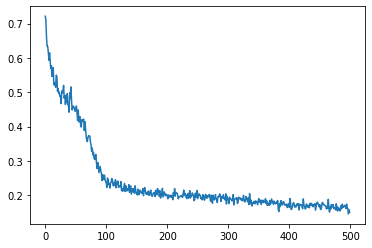

In [8]:
plt.plot(maml.meta_losses)

In [31]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.MSELoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y)
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

In [32]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='lower right')
  plt.show()

[2.8844096660614014, 5.984084606170654, 0.7597700953483582, 0.24385078251361847, 0.2403685599565506, 0.23654308915138245, 0.2271205633878708, 0.22443857789039612, 0.21357698738574982, 0.21068798005580902]


<ipython-input-31-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


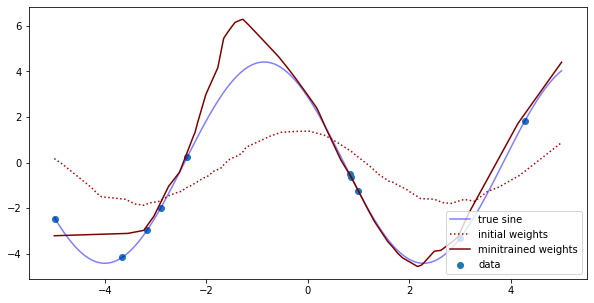

In [36]:
K=10
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)